Intersectionality in Mental Health Care
=======================================


## <font color='red'>Go thorugh Section 8 for "TPR - True Positive Rate" analysis</font>

# 1. Package Installation and Imports

In [1]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 1.4 MB/s eta 0:00:00


In [2]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
from sklearn.datasets import fetch_openml

# 2. Import Data

In [3]:
# Read in dataset
data_openml = fetch_openml(data_id=45040)
data = data_openml.data
data["Diagnosis"] = data_openml.target

# Partition the data into train and test sets
train = data.loc[data.dataset == "train"]
test = data.loc[data.dataset == "test"]

train = train.drop("dataset", axis=1)
test = test.drop("dataset", axis=1)


# This function formats the data for stacked bar graphs
def grouppivot(labelgroup, yvalue, dataset, SZonly=False):
    # Select only columns with a SZ diagnosis
    if SZonly:
        dataset = dataset.loc[dataset.Diagnosis == 0]

    # Group by label group, and normalize by y value within those groups
    grouped = (
        dataset.groupby([labelgroup])[yvalue]
        .value_counts(normalize=True)
        .rename("percentage")
        .reset_index()
    )

    pivot = pd.pivot_table(
        grouped, index=labelgroup, columns=yvalue, values="percentage", aggfunc="sum"
    )
    return pivot

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# 3. Exploring the data


In [4]:
train.head()

,Sex,Race,Housing,Delay,Anhedonia,Dep_Mood,Sleep,Tired,Appetite,Rumination,Concentration,Psychomotor,Delusion,Suspicious,Withdrawal,Passive,Tension,Unusual_Thought,Diagnosis
0,Male,Asian,Stable,No,6.859778,8.596433,5.835555,4.249037,4.120215,4.663982,5.112734,2.055298,4.967700,0.339114,4.168202,6.281626,8.124157,1.869677,1
1,Male,Hispanic,Stable,No,9.833686,8.148029,4.497432,6.308813,6.270848,5.398494,5.716011,6.071951,2.477303,4.355527,2.559291,4.240824,4.005548,1.069391,0
2,Female,Black,Unstable,No,5.663383,4.076933,6.460087,6.918369,3.322668,5.549999,5.797641,5.523801,3.343273,0.725848,4.975947,5.987116,7.064453,4.383587,1
3,Female,Black,Stable,Yes,7.265911,6.812793,6.334380,5.264936,3.403835,7.229377,5.897029,4.190843,2.195623,1.535735,4.337831,5.536262,7.429212,0.887562,0
4,Male,White,Stable,Yes,7.476635,6.901016,8.782125,5.199603,5.085312,2.251041,10.019488,3.782775,3.251150,5.779466,4.654906,4.517311,6.460591,2.613142,1


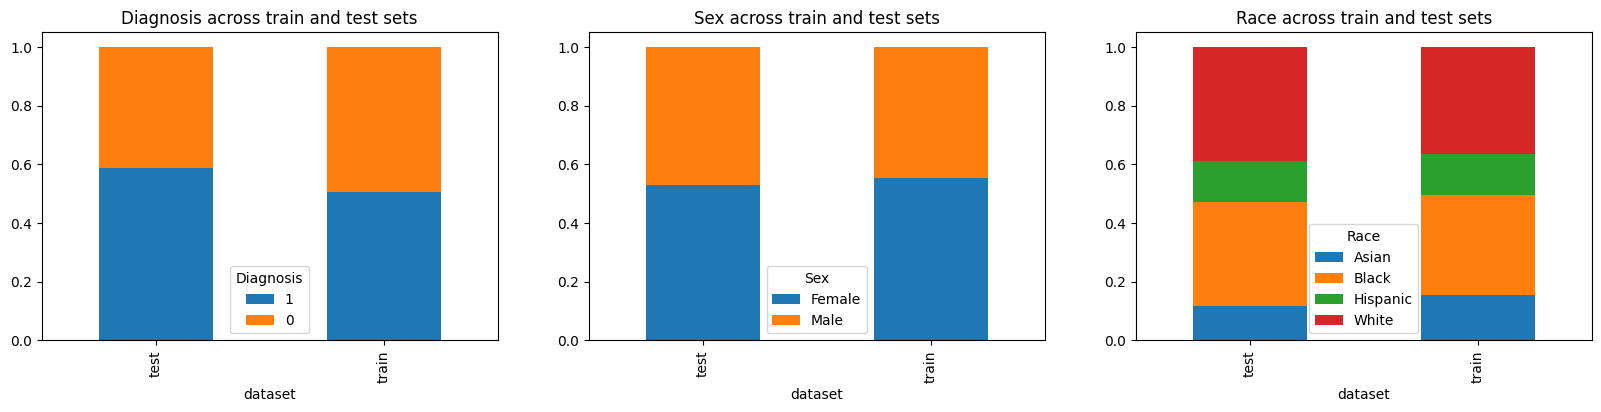

In [5]:
# Format graphs
diagnosis = grouppivot("dataset", "Diagnosis", data)
sex = grouppivot("dataset", "Sex", data)
race = grouppivot("dataset", "Race", data)

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
diagnosis[[1, 0]].plot.bar(stacked=True, ax=axs[0])

axs[0].set_title("Diagnosis across train and test sets")
sex.plot.bar(stacked=True, ax=axs[1])

axs[1].set_title("Sex across train and test sets")
race.plot.bar(stacked=True, ax=axs[2])

axs[2].set_title("Race across train and test sets")
fig.show()

# 4. Preprocessing

In [6]:
# Split the data into x (features) and y (diagnosis)
trainx = train.drop("Diagnosis", axis=1)
trainy = train.Diagnosis

testx = test.drop("Diagnosis", axis=1)
testy = test.Diagnosis

In [7]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Perform one hot encoding
categories = ["Sex", "Race", "Housing", "Delay"]  # Categorial variables


# Define a function for one hot encoding
def onehot(data, categories=categories):
    ordinalencoder = OneHotEncoder()
    onehot = ordinalencoder.fit_transform(data[categories])

    columns = []
    for i, values in enumerate(ordinalencoder.categories_):
        for j in values:
            columns.append(str(categories[i] + "_" + j))

    return pd.DataFrame(onehot.toarray(), columns=columns)


# Apply transformation to data
trainx = trainx.reset_index(drop=True).join(onehot(trainx))
testx = testx.reset_index(drop=True).join(onehot(testx))

# Drop the original categories
trainx = trainx.drop(categories, axis=1)
testx = testx.drop(categories, axis=1)

# 5. Training

In [8]:
# Defining a logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=1)

We train the model and apply it to generate predictions on our test set.


In [9]:
# Training the model with all available features
model.fit(trainx, trainy)

# generate 10000 predictions for 10000 train individuals
train_predictions = model.predict(trainx)
print("Training accuracy: ", skm.accuracy_score(trainy, train_predictions))  # Training accuracy

# generate 1000 predictions for 1000 test individuals
predictions = model.predict(testx)
print("Test accuracy: ", skm.accuracy_score(testy, predictions))  # Test accuracy

Training accuracy:  0.9306
Test accuracy:  0.938


We notice that the train and test accuracy are all fairly good. We can
visualize the performance of the model further by looking at a confusion
matrix.


# 6. Metrics Understanding

Sensitivity:  0.9404761904761905 
Specificity:  0.9344660194174758 
PPV:  0.9534482758620689 
NPV:  0.9166666666666666


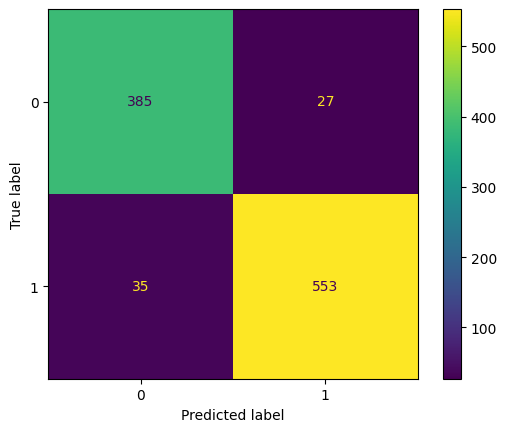

In [10]:
def confusionmatrix(truelabels, predictions):
    confusion_matrix = skm.confusion_matrix(truelabels, predictions)
    tn, fp, fn, tp = confusion_matrix.ravel()
    print(
        "Sensitivity: ",
        tp / (tp + fn),
        "\nSpecificity: ",
        tn / (tn + fp),
        "\nPPV: ",
        tp / (tp + fp),
        "\nNPV: ",
        tn / (tn + fn),
    )

    skm.ConfusionMatrixDisplay(confusion_matrix).plot()


confusionmatrix(testy, predictions)

# 7. FPR - False Postive Rate

## 7.1 Relative FPR

In [11]:
from fairlearn.metrics import MetricFrame, false_positive_rate


def f(truelabels, predictions):
    # Define race to be the sensitive variable
    sensitive = test.Race

    # Define a MetricFrame using a FPR of the defined sensitive features, using the true labels and
    # predictions
    fmetrics = MetricFrame(
        metrics=false_positive_rate,
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    # Compute the Relative FPR relative to white individuals.
    results = pd.DataFrame(
        [fmetrics.by_group, fmetrics.by_group / fmetrics.by_group.White],
        index=["FPR", "Relative FPR"],
    )
    return results


f(testy, predictions)

Race,Asian,Black,Hispanic,White
FPR,0.033898,0.126214,0.057971,0.044199
Relative FPR,0.766949,2.855583,1.311594,1.000000


## 7.2 Intersectionality Function

In [12]:
def intersectionalf(truelabels, predictions):
    # Sensitive features are now the intersection of race and sex
    sensitive = pd.DataFrame(np.stack([test.Race, test.Sex], axis=1), columns=["Race", "Sex"])

    fmetrics = MetricFrame(
        metrics=false_positive_rate,
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    results = pd.DataFrame(
        [fmetrics.by_group, fmetrics.by_group / fmetrics.by_group.White.Male],
        index=["FPR", "Relative FPR"],
    )
    return results


intersectionalf(testy, predictions)

Race          Asian               Black        Hispanic          White  \
Sex          Female      Male    Female  Male    Female Male    Female   
FPR             0.0  0.076923  0.076923  0.28  0.108108  0.0  0.037383   
Relative FPR    0.0  1.423077  1.423077  5.18  2.000000  0.0  0.691589   

Race                    
Sex               Male  
FPR           0.054054  
Relative FPR  1.000000

# 8. TPR - True Positive Rate

## 8.1. Relative TPR

In [13]:
from fairlearn.metrics import MetricFrame, true_positive_rate


def f(truelabels, predictions):
    # Define race to be the sensitive variable
    sensitive = test.Race

    # Define a MetricFrame using a TPR of the defined sensitive features, using the true labels and
    # predictions
    fmetrics = MetricFrame(
        metrics=true_positive_rate,
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    # Compute the Relative TPR relative to white individuals.
    results = pd.DataFrame(
        [fmetrics.by_group, fmetrics.by_group / fmetrics.by_group.White],
        index=["TPR", "Relative TPR"],
    )
    return results


f(testy, predictions)

Race,Asian,Black,Hispanic,White
TPR,0.910714,0.964567,0.887324,0.937198
Relative TPR,0.971742,1.029203,0.946784,1.000000


## 8.2 Intersectionality Function

In [14]:
def intersectionalf(truelabels, predictions):
    # Sensitive features are now the intersection of race and sex
    sensitive = pd.DataFrame(np.stack([test.Race, test.Sex], axis=1), columns=["Race", "Sex"])

    fmetrics = MetricFrame(
        metrics=true_positive_rate,
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    results = pd.DataFrame(
        [fmetrics.by_group, fmetrics.by_group / fmetrics.by_group.White.Male],
        index=["TPR", "Relative TPR"],
    )
    return results


intersectionalf(testy, predictions)

Race             Asian               Black            Hispanic            \
Sex             Female      Male    Female      Male    Female      Male   
TPR           0.892857  0.928571  0.942529  0.976048  0.888889  0.885714   
Relative TPR  0.914372  0.950947  0.965240  0.999567  0.910308  0.907057   

Race             White            
Sex             Female      Male  
TPR           0.909836  0.976471  
Relative TPR  0.931760  1.000000

# 9. Frequency of diagnoses
- stratified by intersectional groups

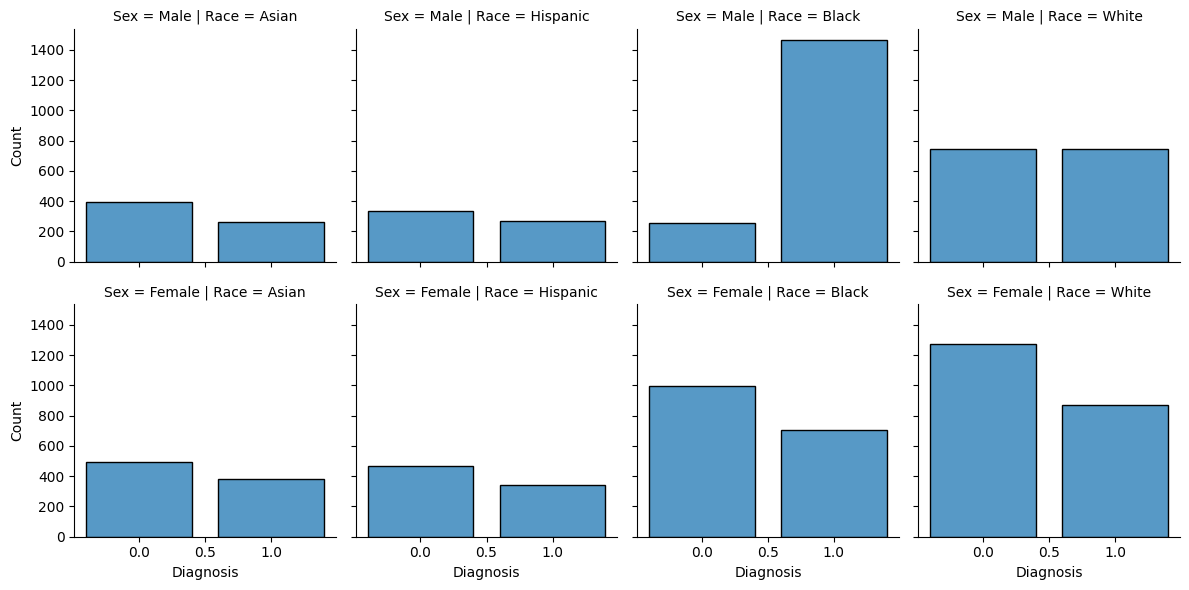

In [15]:
m = sns.FacetGrid(train, row="Sex", col="Race")
m.map(sns.histplot, "Diagnosis", discrete=True, shrink=0.8)

# 10. Fairness through Unawareness?

In [16]:
race_cat = ["Race_Asian", "Race_Black", "Race_Hispanic", "Race_White"]
trainx_norace = trainx.drop(race_cat, axis=1)
testx_norace = testx.drop(race_cat, axis=1)

In [17]:
# Define and train a second model
model2 = LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=1)
model2 = model2.fit(trainx_norace, trainy)

train_predictions = model2.predict(trainx_norace)
print("Training accuracy: ", skm.accuracy_score(trainy, train_predictions))  # Training accuracy

predictions = model2.predict(testx_norace)
print("Test accuracy: ", skm.accuracy_score(testy, predictions))  # Test accuracy

Training accuracy:  0.9297
Test accuracy:  0.937


In [18]:
f(testy, predictions)

Race,Asian,Black,Hispanic,White
TPR,0.910714,0.968504,0.915493,0.917874
Relative TPR,0.992199,1.055160,0.997405,1.000000


Oh yikes - by removing race from our model, the FPR for the Black
population has increased to 3.8x that of our reference group.

Does intersectional fairness show a similar trend?


In [19]:
intersectionalf(testy, predictions)

Race             Asian               Black            Hispanic            \
Sex             Female      Male    Female      Male    Female      Male   
TPR           0.892857  0.928571  0.942529  0.982036  0.916667  0.914286   
Relative TPR  0.960669  0.999096  1.014113  1.056621  0.986287  0.983725   

Race             White            
Sex             Female      Male  
TPR           0.909836  0.929412  
Relative TPR  0.978938  1.000000

# 11. Feature evaluation

Gets the weights associated with each feature, and scales them from
0-100


In [20]:
weights = pd.DataFrame(model.coef_[0], trainx.columns, columns=["Weight"])
scaler = MinMaxScaler((0, 100))
scaled_weights = pd.DataFrame(
    scaler.fit_transform(abs(weights)), trainx.columns, columns=weights.columns
)
scaled_weights.sort_values(by=["Weight"], ascending=False)

,Weight
Rumination,100.000000
Housing_Unstable,90.856881
Tension,87.331226
Race_White,82.567478
Delusion,55.672193
Unusual_Thought,53.262133
Suspicious,45.994436
Concentration,45.474086
Anhedonia,41.976083
Tired,41.872639


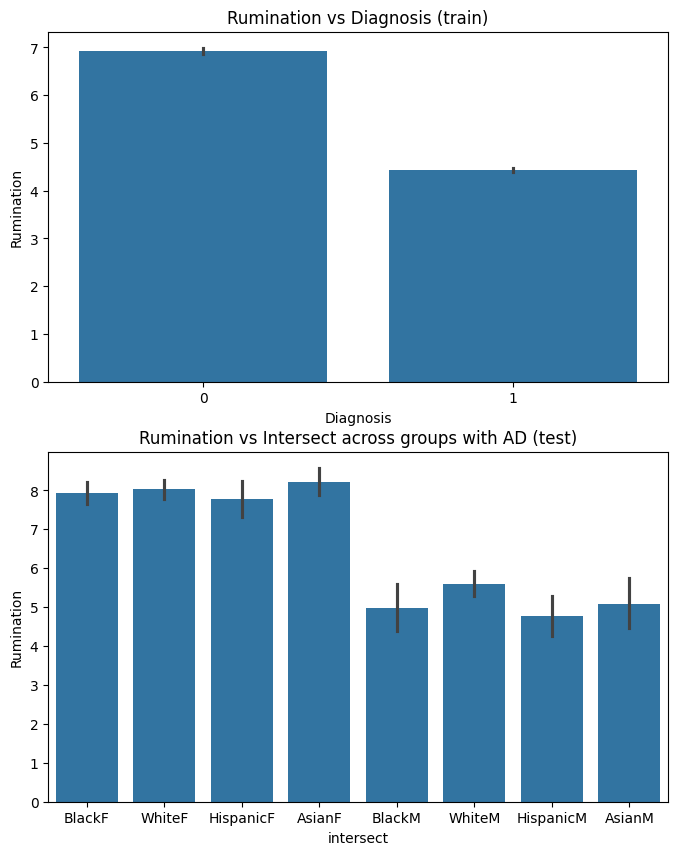

In [21]:
# Reloading the data for analysis
train = data.loc[data.dataset == "train"].drop("dataset", axis=1)
test = data.loc[data.dataset == "test"].drop("dataset", axis=1)

train["Diagnosis"] = train["Diagnosis"].astype(int)
test["Diagnosis"] = test["Diagnosis"].astype(int)

# Create new intersect column for plotting
test["intersect"] = ""
test.loc[(test["Sex"] == "Male") & (test["Race"] == "White"), "intersect"] = "WhiteM"
test.loc[(test["Sex"] == "Male") & (test["Race"] == "Black"), "intersect"] = "BlackM"
test.loc[(test["Sex"] == "Male") & (test["Race"] == "Hispanic"), "intersect"] = "HispanicM"
test.loc[(test["Sex"] == "Male") & (test["Race"] == "Asian"), "intersect"] = "AsianM"
test.loc[(test["Sex"] == "Female") & (test["Race"] == "White"), "intersect"] = "WhiteF"
test.loc[(test["Sex"] == "Female") & (test["Race"] == "Black"), "intersect"] = "BlackF"
test.loc[(test["Sex"] == "Female") & (test["Race"] == "Hispanic"), "intersect"] = "HispanicF"
test.loc[(test["Sex"] == "Female") & (test["Race"] == "Asian"), "intersect"] = "AsianF"

fig, axs = plt.subplots(2, 1, figsize=(8, 10))
sns.barplot(x="Diagnosis", y="Rumination", data=train, ax=axs[0])
axs[0].set_title("Rumination vs Diagnosis (train)")

sns.barplot(
    x="intersect",
    y="Rumination",
    data=test.loc[test.Diagnosis == 0],
    ax=axs[1],
    order=["BlackF", "WhiteF", "HispanicF", "AsianF", "BlackM", "WhiteM", "HispanicM", "AsianM"],
)
axs[1].set_title("Rumination vs Intersect across groups with AD (test)")

plt.show()

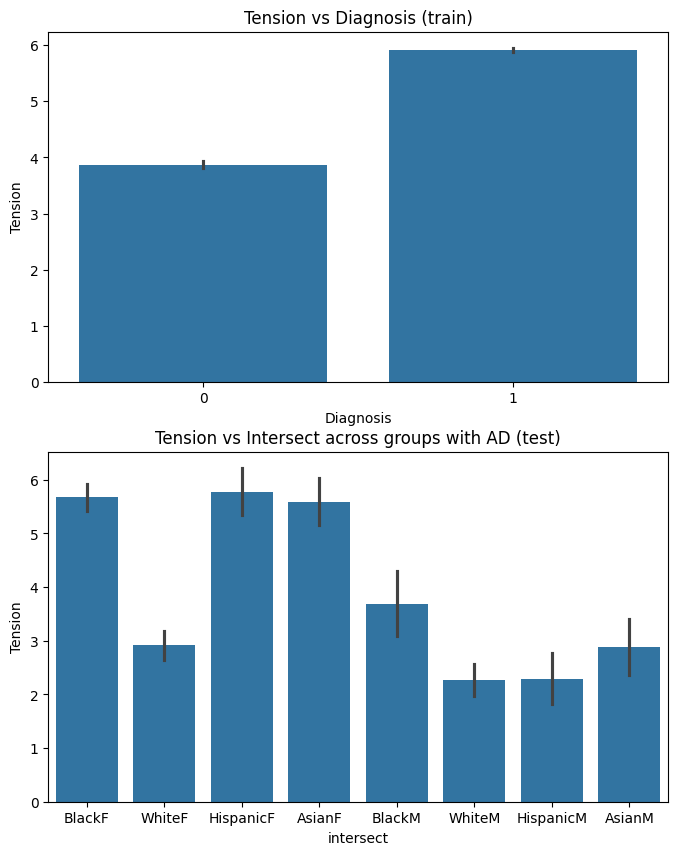

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
sns.barplot(x="Diagnosis", y="Tension", data=train, ax=axs[0])
axs[0].set_title("Tension vs Diagnosis (train)")

sns.barplot(
    x="intersect",
    y="Tension",
    data=test.loc[test.Diagnosis == 0],
    ax=axs[1],
    order=["BlackF", "WhiteF", "HispanicF", "AsianF", "BlackM", "WhiteM", "HispanicM", "AsianM"],
)
axs[1].set_title("Tension vs Intersect across groups with AD (test)")

plt.show()